## Les instances de classe du programme ZuPer

Dans la classe du programme informatique ZuPer, nous retrouvons sept types de variables classées en fonctions de leurs utilisations pour faire les calculs. Nous retrouvons les :

<ol>
    <li>Variables pour stocker le fichier Feflow.</li>
    <li>Variables pour les propriétés du maillage utilisé et retrouvé dans le fichier Feflow.</li>
    <li>Variables pour calculer les coefficients pour la comparaison des résultats.</li>
    <li>Variables pour stocker les champs de valeurs des paramètres (conductivité hydraulique et recharge en eau souterraine).</li>
    <li>Variables pour caractériser le type de variogramme utilisé dans les simulations aléatoires des champs de paramètres.</li>
    <li>Variables pour stocker les résultats</li>
    <li>Variables pour l'affichage des graphes</li>
</ol>

Nous allons discuter de ces différents groupes les uns après les autres. Commençons d'abord par créer notre objet zuper contenant ici les instances de classe et la description des premiers paramètres :

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import ifm as ifm

class zuper:

    doc = ''
    
    #####################
    # Instance variable #
    #####################
    
    def __init__(self, url_file):
        
        #get feflow file
        self.doc = ifm.loadDocument(url_file)

        print("Object created !")

In [105]:
data = zuper(r'C:\zuper\final_case.fem')

Object created !


-----------------------------------------------------------------------------------------------------------------------------------------------------------

#### 1. Variables pour stocker le fichier Feflow

Le premier groupe est constituté de la variable <b>doc</b> utilisé pour stocker toutes les informations qui caractérise le fichier Feflow. Il permet alors de se balader dans les propriétés du fichier pour ensuite changer et manipuler les options à notre guise.

In [106]:
data.doc


[ IFM FEM document ]
  file path:      C:\zuper\final_case.fem
  file version:   8.1.0.21090
  file type:      BINARY
  description:    ''
  problem class:  saturated flow and mass transport with age process
  projection:     phreatic (2D)
  time class:     transient/transient
  mesh:           ndm=2,np=35301,ne=34892,quadrangles
  extent:         1000,1000 -> 4000,8000
Supermesh: 
  mesh:           nelems=1,nnodes=8,npoly=1,nlines=0,npoints=0

Cette variable est donc la racine du fichier Feflow initialisé dans le programme informatique ZuPer, et est obtenue en utilisant la méthode <b>ifm.loadDocument</b> en utilisant l'url du fichier Feflow de la manière suivante :

In [107]:
doc = data.doc

#### 2. Variables pour les propriétés du maillage utilisé et retrouvé dans le fichier Feflow

Ensuite, nous avons le groupe de variables comprenant les propriétés du maillage trouvable dans le fichier Feflow à partir de la variable <b>doc</b>

Le nombre de noeuds (<b>nnodes</b>) et d'éléments (<b>nelements</b>) totaux du maillage sont obtenues par les méthodes suivantes :

In [108]:
nnodes = doc.getNumberOfNodes()
nelements = doc.getNumberOfElements()

print("Nombre de noeuds : "+str(nnodes))
print("Nombre d'éléments : "+str(nelements))

Nombre de noeuds : 35301
Nombre d'éléments : 34892


Les matrices de coordonnées (<b>x</b> et <b>y</b>) des deux axes x et y sont obtenues ainsi :

In [109]:
x, y = np.zeros((nnodes,)), np.zeros((nnodes,))
for i in range(nnodes):
    x[i] = doc.getX(i)
    y[i] = doc.getY(i)

print("Coordonnées de l'axe x sous format liste : \n\nx = ",x,"\n")
print("Coordonnées de l'axe y sous format liste : \n\ny = ",y)

Coordonnées de l'axe x sous format liste : 

x =  [1000.         1024.59016393 1049.18032787 ... 3950.81967213 3975.40983607
 4000.        ] 

Coordonnées de l'axe y sous format liste : 

y =  [8000. 8000. 8000. ... 1000. 1000. 1000.]


Les valeurs minimum (<b>xmin</b> et <b>ymin</b>) et maximum (<b>xmax</b> et <b>ymax</b>) des deux axes x et y sont obtenues ainsi :

In [110]:
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)

print("Valeur minimum en axe x : "+str(xmin))
print("Valeur minimum en axe y : "+str(ymin))
print("Valeur maximum en axe x : "+str(xmax))
print("Valeur maximum en axe y : "+str(ymax))

Valeur minimum en axe x : 999.9999999999998
Valeur minimum en axe y : 999.9999999999993
Valeur maximum en axe x : 4000.000000000001
Valeur maximum en axe y : 8000.000000000002


Les valeurs des espaces entres les noeuds (<b>dx</b> et <b>dy</b>), le nombre d'éléments (<b>nbx_el</b> et <b>nby_el</b>) et de noeuds (<b>nbx_nd</b> et <b>nby_nd</b>) par axe, ainsi que la surface d'une cellule (<b>s</b>) sont obtenues de la manière suivante :

In [111]:
dx = x[1] - x[0]
nbx_el = int(np.round( (xmax - xmin)/dx ))
dy = y[0] - y[nbx_el + 1]
nby_el = int(np.round( (ymax - ymin)/dy ))
s = dx*dy
nbx_nd, nby_nd = nbx_el + 1, nby_el + 1

print("Nombre de noeuds en axe x : "+str(nbx_nd))
print("Nombre de noeuds en axe y : "+str(nby_nd))
print("Nombre d'éléments en axe x : "+str(nbx_el))
print("Nombre d'éléments en axe y : "+str(nby_el))
print("Aire d'une cellule du maillage : "+str(s))
print("Espace entre deux noeuds en axe x : "+str(dx))
print("Espace entre deux noeuds en axe y : "+str(dy))

Nombre de noeuds en axe x : 123
Nombre de noeuds en axe y : 287
Nombre d'éléments en axe x : 122
Nombre d'éléments en axe y : 286
Aire d'une cellule du maillage : 601.8571592341935
Espace entre deux noeuds en axe x : 24.590163934425846
Espace entre deux noeuds en axe y : 24.475524475524253


Les valeurs de l'origine du maillage (<b>ox</b> et <b>oy</b>) du fichier Feflow sont obtenues en utilisant les méthodes suivantes :

In [112]:
ox, oy = doc.getOriginX(), doc.getOriginY()

print("Origine en axe x : "+str(ox))
print("Origine en axe y : "+str(oy))

Origine en axe x : 0.0
Origine en axe y : 0.0


Les valeurs caractéristique du puits retrouvé dans le maillage sont obtenues ainsi pour le débit du puits (<b>qw</b>), les coordonnées du puits dans le maillage (<b>xw</b> ; <b>yw</b>) :

In [113]:
qw = float( str( doc.createWellManager().getWells()[0].getPropertyValue(8) ).split('[')[0] )
xw = int(float(str( doc.createWellManager().getWells()[0].getPropertyValue(3)).split(' ')[0]))
yw = int(float(str( doc.createWellManager().getWells()[0].getPropertyValue(4)).split(' ')[0]))

print("Débit du puits : "+str(qw))
print("Coordonnées du puits : "+str((xw, yw)))

Débit du puits : 3500.0
Coordonnées du puits : (2524, 1856)


Les différents ID du puits selon l'utilisation d'une liste (<b>id_well</b>) ou selon l'utilisation d'une matrice (<b>id_well_mesh</b>) sont obtenues de la manière suivante :

In [114]:
for i in range(nnodes):
    if int( x[i] ) == xw and int( y[i] ) == yw:
        id_well = i

x.shape = (nby_nd, nbx_nd)
y.shape = (nby_nd, nbx_nd)

for i in range(nby_nd):
    for j in range(nbx_nd):
        if int(x[i][j])==xw and int(y[i][j])==yw:
            id_well_mesh = [i,j]

print("ID du puits pour liste : "+str(id_well))
print("ID du puits pour matrice : "+str(( id_well_mesh[0], id_well_mesh[1] )) )

ID du puits pour liste : 30935
ID du puits pour matrice : (251, 62)


-----------------------------------------------------------------------------------------------------------------------------------------------------------

#### 3. Variables pour calculer les coefficients pour la comparaison des résultats

Ce groupe de variables permet le stockage temporelle des valeurs obtenues pour chaque coefficients permettant de caractériser une aire d'alimentation. On retrouve la surface de l'aire d'alimentation ($A_{zu}$) mesuré en hectard, le coefficient d'efficacité ($\eta$) qui est expliqué dans le fichier ..., puis le nombre de noeuds pris en compte pour délimiter l'aire d'alimentation ($\tau$).

Efficacité : 55.55
Nombre de noeuds : 3130
Surface d'une zone Zu : 188.38129084030257





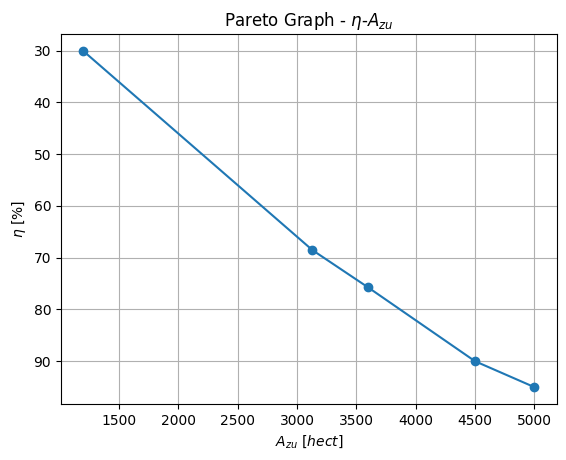

In [115]:
n = 55.55
tau = 3130
a_zu = tau * s / 10000

print("Efficacité : "+str(n))
print("Nombre de noeuds : "+str(tau))
print("Surface d'une zone Zu : "+str(a_zu))
print("\n\n")

tab_n = [30.12, 68.55, 75.76, 90.0, 95.0]
tab_a_zu = [1200, 3130, 3600, 4500, 5000]

plt.figure()
plt.plot(tab_a_zu, tab_n, 'o-')
plt.grid()
plt.gca().invert_yaxis()
plt.xlabel(r'$A_{zu}$ [$hect$]')
plt.ylabel(r'$\eta$ [%]')
plt.title(r'Pareto Graph - $\eta$-$A_{zu}$')
plt.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------

#### 4. Variables pour stocker les champs de valeurs des paramètres

Ce groupe de variables permet le stockage des champs de valeurs des paramètres (conductivité hydraulique et recharge en eau souterraine). En premier, il y a <b>r_matrix</b> et <b>k_matrix</b> qui sont les champs de valeurs de références pour les calculs déterministes et stochastiques.

In [116]:
import geone as gn

In [117]:
cov_mod = gn.covModel.CovModel2D([('spherical', {'w':0.25, 'r':[1300, 1300]})], 0, 'title')
cov_mod

*** CovModel2D object ***
name = 'title'
number of elementary contribution(s): 1
elementary contribution 0
    type: spherical
    parameters:
        w = 0.25
        r = [1300, 1300]
angle: alpha = 0 deg.
    i.e.: the system Ox'y', supporting the axes of the model (ranges),
    is obtained from the system Oxy by applying a rotation of angle -alpha.
*****

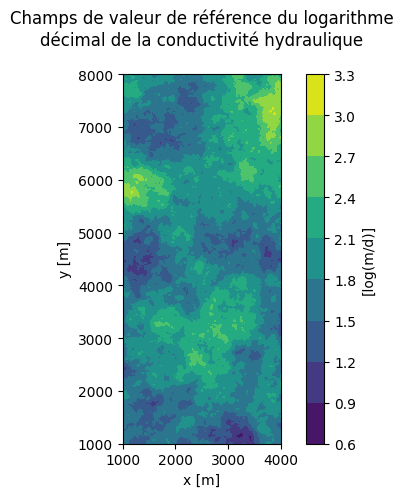

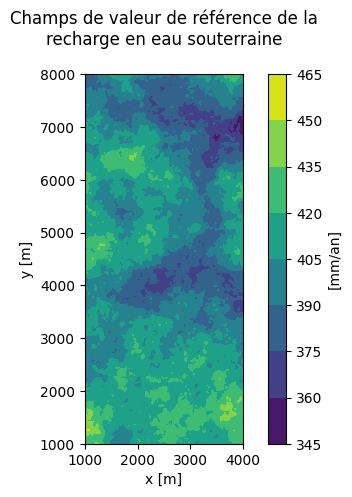

In [118]:
k_matrix = gn.geosclassicinterface.simulate2D(
    cov_mod,
    (nbx_nd, nby_nd),
    (dx, dy),
    (ox, oy),
    mean=1.8,
    var=0.35**2,
    x=None,
    v=None,
    seed=8948474,
    verbose=0
)['image'].val[0][0]

r_matrix = gn.geosclassicinterface.simulate2D(
    cov_mod,
    (nbx_nd, nby_nd),
    (dx, dy),
    (ox, oy),
    mean=400,
    var=15**2,
    x=None,
    v=None,
    seed=7528660,
    verbose=0
)['image'].val[0][0]

plt.figure()
plt.contourf(x, y, k_matrix)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title("Champs de valeur de référence du logarithme\ndécimal de la conductivité hydraulique\n")
plt.colorbar().set_label('[log(m/d)]')
plt.axis([xmin, xmax, ymin, ymax])
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks((1000, 2000, 3000, 4000))
plt.show()

plt.figure()
plt.contourf(x, y, r_matrix)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title("Champs de valeur de référence de la\nrecharge en eau souterraine\n")
plt.colorbar().set_label('[mm/an]')
plt.axis([xmin, xmax, ymin, ymax])
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks((1000, 2000, 3000, 4000))
plt.show()

Les paramètres <b>r_mean</b> et <b>k_mean</b> sont les moyennes de chaque champs présenté ci-dessus. Pour la recharge moyenne, un calcul par la moyenne arithémtique est faite, contrairement à une moyenne géométrique pour la conductivité hydraulique moyenne. Cela se défini théoriquement ainsi :

<ul>
    <li>$r_{mean}~~=~~\sum_{i=1}^{N} r_{i}$</li>
    <br>
    <li>$k_{mean}~~=~~\frac{1}{N}\sum_{i=1}^{N} log_{10}(k_{i})$</li>
</ul>

Numériquement, il existe des méthodes pour faire ces calculs de moyennes, et sont les suivantes :

In [119]:
from scipy.stats import gmean

r_mean = np.mean(r_matrix, axis=None)
k_mean = gmean(k_matrix, axis=None)

print("Recharge moyenne de référence : "+str(r_mean))
print("Conductivité hydraulique de référence : "+str(k_mean))

Recharge moyenne de référence : 400.60489835476926
Conductivité hydraulique de référence : 1.7978992499243802


Enfin, pour ce qui est des paramètres considérés dans le modèle numérique et qui permettra par la suite d'obtenir les résultats, nous avons l'épaisseur de l'aquifère (<b>b</b>) et la porosité (<b>f</b>). Comme l'aquifère dans le modèle est de type libre, il faut pouvoir calculer l'épaisseur selon la manière suivante : 

<ul>
    <li>$b$ = $z_{top}$ - $z_{bottom}$</li>
</ul>
où $z_{top}$ est la hauteur du sommet de l'aquifère et $z_{bottom}$ la hauteur de sa base. Concernant la porosité, elle est défini comme l'emmagasinement spécifique et est défini directement dans le fichier Feflow.

Les valeurs de ces deux paramètres sont trouvables dans la variable <b>doc</b> en utilisant les méthodes suivantes à partir d'ID que le module <u>ifm</u> contient :

In [120]:
z_top, z_bot = doc.getParamValue(108, 0), doc.getParamValue(106, 0)
b = z_top - z_bot
f = doc.getParamValue(201, 0)

print("Sommet de l'aquifère : "+str(z_top))
print("Base de l'aquifère : "+str(z_bot))
print("Épaisseur de l'aquifère : "+str(b))
print("Porosité de l'aquifère : "+str(f))

Sommet de l'aquifère : 100.0
Base de l'aquifère : 0.0
Épaisseur de l'aquifère : 100.0
Porosité de l'aquifère : 0.30000001192092896


#### 5. Variables pour caractériser le type de variogramme utilisé et les données conditionantes dans les simulations aléatoires des champs de paramètres

Ce groupe de variables est très important, car il détermine comment les simulations aléatoires de champs de valeurs sont faites. Ces simulations se basent sur le principe de simulation gaussienne séquentielle, un algorithme stochastique permettant de générer des réalisations de données grâce à des fonctions multigaussiennes créé dans les années 80 par le groupe de André Journel à l'université de Stanford en Angleterre. Ces générations de données sont faites avec le module Geone. Pour cela, il faut définir un type de variogramme (<b>el</b>) contenant son type, son sill et le degré d'anisotropie. La variable <b>alpha</b> correspond à l'angle d'anisotropie souhaités.

Concernant les données conditionnantes, le programme ZuPer contient deux variables, l'une pour la position du maillage (<b>pos_cond</b>) et l'autre pour la valeur du paramètre (<b>val_cond</b>) à la position souhaitée. Ce sont les deux des listes Python.

Pour plus d'information, veuillez vous référez à la fiche de description des méthodes du module Geone : https://github.com/randlab/geone

#### 6. Variables pour stocker les résultats

Ce groupe de variable vont permettre de stocker temporellement les données des résultats obtenues durant les calculs des aires d'alimentation. Elles seront ensuite représentées graphiquement avec le module Python <u>matplotlib</u>. Les variables <b>dict_params</b> (pour les paramètres géologie et hydrogéologique) et <b>dict_results</b> (pour les résultats) sont de type "dictionnaire Python" pour améliorer la capacité de stockage et la rapidité de manipulation par l'ordinateur. Les résultats stockés sont :

<ul>
    <li>La conductivité hydraulique</li>
    <li>La recharge en eau souterraine</li>
    <li>La charge hydraulique</li>
    <li>L'âge moyen de l'eau souterraine</li>
    <li>L'espérance de vie ou temps de sortie de l'eau souterraine </li>
    <li>La probabilité de capture de l'eau souterraine</li>
    <li>Les contributions du paysage</li>
    <li>La zone Zu</li>
</ul>

De plus, une variable (<b>dtframe_constant</b>) de type dataFrame, obtenue avec le module Python <u>Pandas</u>, est utilisé pour stocker toutes les paramètres du modèle numérique qui peuvent intervenir dans les simulations numériques avec Feflow pour les calculs des résultats et de la zone Zu.

In [121]:
import pandas as pds

dict_params = {'perm':[], 'rech':[]}
dict_results = {'charge':[], 'age':[], 'exit-time':[], 'probability':[], 'contributions':[], 'zu':[]}

dtframe_constant = pds.DataFrame([])

#### 7. Variables pour l'affichage des graphes

Ce dernier groupe de variable permet le stockage d'information pour les représentations graphiques de chaque résultat. Cela regroupe des options d'affichage tel que les noms des paramètres (<b>name_params</b>), des résultats (<b>name_results</b>) pour les dictionnaires et les noms des coefficients (<b>name_coeff</b>) et des données (<b>title</b>) pour les graphes ; les carte de couleur pour chaque donnée (<b>cmap</b>) retrouvées dans le module Python <u>Matplotlib.cm</u> ; les unités de chaque donnée (<b>unity</b>) et leur symbole respectif (<b>symb</b>).

La plupart de ces données sont de type liste contenant des chaînes de caractère. Pour ce qui est de <b>symb</b>, ce sont des données de type rawstring pour pouvoir afficher des caractères de typologie cyrilique.

In [122]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

name_params = ['perm', 'rech']
name_results = ['charge', 'age', 'meanlife', 'probability', 'contributions', 'zu', 'concentration_cr', 'concentration_cm']
cmap = [cm.viridis, cm.viridis, cm.Oranges, cm.Reds, cm.Blues, cm.Greens, cm.Greys, cm.plasma, cm.viridis, cm.viridis]
title = ['permeability', 'recharge', 'charge', 'age', 'exit-time', 'capture probabilities', 'contributions', 'zone Zu', 'Concentration de masse Cr', 'Concentration de masse Cm']
unity = ['[-]', '[m/d]', '[m]', '[d]', '[d]', '[-]', '[m3/d]', '[-]', '[mg/L]', '[mg/L]']
symb = [r'$\eta$ [%]', r'$a_{zu}$ [hect]', r'$c_{m}$ [mg/L]', r'$\rho$ [%]', r'c_{r} [mg/L]']
name_coeff = ['Coefficient of efficiency', 'Surface of Zu', 'Concentration Cm', 'Ratio protection', 'Concentration Cr']